# Deep Learning on 20 Newsgroups

## Project Description and Motivation

I am aiming to explore how different text-representation methods affect performance on a multi-class document classification problem. To be specific, I will be comparing a traditional TF-IDF + Logistic Regression model with a deep learning model that uses pre-trained GloVe word embeddings.

Since this is a supervised learning task, the documents already have classes that they are in like sports, science, politics, etc. By modeling this dataset using two different approaches, I will be able to see the limitations of the Logisitic Regression model and the deep learning model.

### Why this Problem Matters

Text classification is one of the most utilized abilities in machine learning today. This allows models to filter spam emails, detect misinformation, or to organizing customer support tickets. This ability to put text into a category is a huge boon in a real life scenario.

The 20 Newsgroups dataset gives a good challenge because there are:

- 20 diverse topics with overlapping vocabulary
- Categories that can be semantically similar
- Documents that vary widely in structure, length, etc.

It will be exciting to see which model will be best at predicting which category the text lies in.


In [1]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
)

from sklearn.linear_model import LogisticRegression

import seaborn as sns
import re
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from collections import Counter
from torch.nn.utils.rnn import pad_sequence


## Data and Data Cleaning

The dataset is provided through sklearn.datasets.fetch_20newsgroups. This is a widely used text classification dataset. It contains documents from 20 different online discussion groups. Each document has a label from one of twenty categories.

**Citation:**  
Lang, Ken. *“Newsweeder: Learning to Filter Netnews.”* Proceedings of the 12th International Conference on Machine Learning, pp. 331–339, 1995.

Dataset reference page:  
https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html


### Dataset Overview

- **Number of total documents:** ~18,000  
- **Training set size:** ~11,300  
- **Test set size:** ~7,500  
- **Number of classes:** 20  
- **Type of data:** Raw text documents  
- **Task:** Multi-class supervised classification  
- **Examples of categories:**  
  - rec.sport.baseball  
  - sci.space
  - comp.graphics
  - talk.politics.misc
  - soc.religion.christian

### Data Cleaning

Although this dataset comes from a highly used area, I just wanted to be sure that the data was clean and ready to use.

#### Removal of Headers, Footers, and Email Quotes

Newsgroup posts frequently contain email addresses, forwarded text, replies, or usernames. These components introduce vocabulary that does not generalize well. Removing this aides in the modeling of the dataset.

#### Lowercasing and Text

To standardize the text, all documents were converted to lowercase. Special characters were also removed. This removal again will aide in modeling the dataset.

#### Document Length Inspection

The dataset contains documents of widely varying lengths. These range from extremely short posts to long multi-paragraph discussions. Length distributions were analyzed to identify outliers.

#### Summary of Cleaning Decisions

Overall, these cleaning steps help reduce noise while preserving the meaningful semantic content needed for both TF-IDF and GloVe-based deep learning models.


In [2]:
# Load the data

train_raw = fetch_20newsgroups(
    subset="train",
    categories=None,
    remove=("headers", "footers", "quotes"),
)
test_raw = fetch_20newsgroups(
    subset="test",
    categories=None,
    remove=("headers", "footers", "quotes"),
)

X_train_text = train_raw.data
y_train = train_raw.target

X_test_text = test_raw.data
y_test = test_raw.target

target_names = train_raw.target_names

len(X_train_text), len(X_test_text), len(target_names)


(11314, 7532, 20)

In [3]:
# Show a sample of the text & an overview of the data

print("Number of training docs:", len(X_train_text))
print("Number of test docs:", len(X_test_text))
print("Number of classes:", len(target_names))
print("Classes:", target_names)

for i in range(3):
    print("="*80)
    print("Label:", target_names[y_train[i]])
    print(X_train_text[i][:500], "...")


Number of training docs: 11314
Number of test docs: 7532
Number of classes: 20
Classes: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Label: rec.autos
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail. ...
Label: comp.sys.mac.h

In [4]:
# Cleaning up the text

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

X_train_clean = [clean_text(t) for t in X_train_text]
X_test_clean = [clean_text(t) for t in X_test_text]


## Exploratory Data Analysis

### Visualizations

#### Document Length Distribution

The first visualization shows the distribution of document lengths. This is known from the number of words. We see that most of the dataset has around 500 words; however, there are some documents that have more than 15,000 words. This is a very wide range that can bias the models in different ways. Need to be aware of that so we can prepare the text for the deep learning model and truncate or pad it to create a uniform size.

#### Class Distribution

The class distribution plot illustrates the number of documents in the 20 newsgroup categories. No classes are dominating the dataset, which is good for balance and doesn't lead to bias in any one class. There is still a slight imbalance seen, which will lead to the F1 score being crucial to weigh all classes equally.

### Conclusion

- The dataset is clean but highly variable in document length.
- The class distribution is mostly balanced, leading to a fair multi-class analysis
- Text preprocessing is crucial before feeding documents into deep learning models.
- The differing models will learn different aspects of the data, giving crucial insight into our dataset.


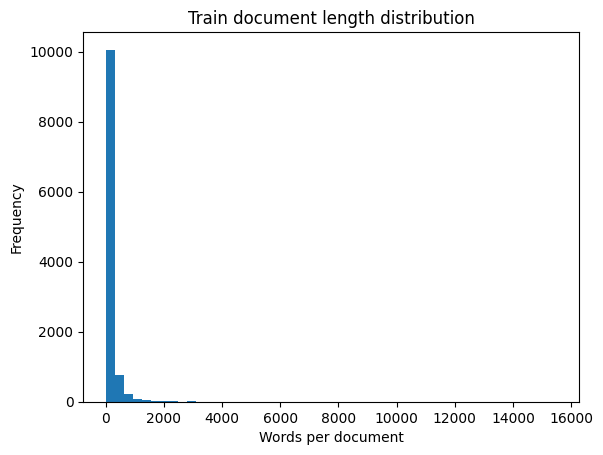

In [8]:
# Showing the document lengths

train_lengths = [len(t.split()) for t in X_train_clean]
test_lengths = [len(t.split()) for t in X_test_clean]

plt.figure()
plt.hist(train_lengths, bins=50)
plt.title("Train document length distribution")
plt.xlabel("Words per document")
plt.ylabel("Frequency")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


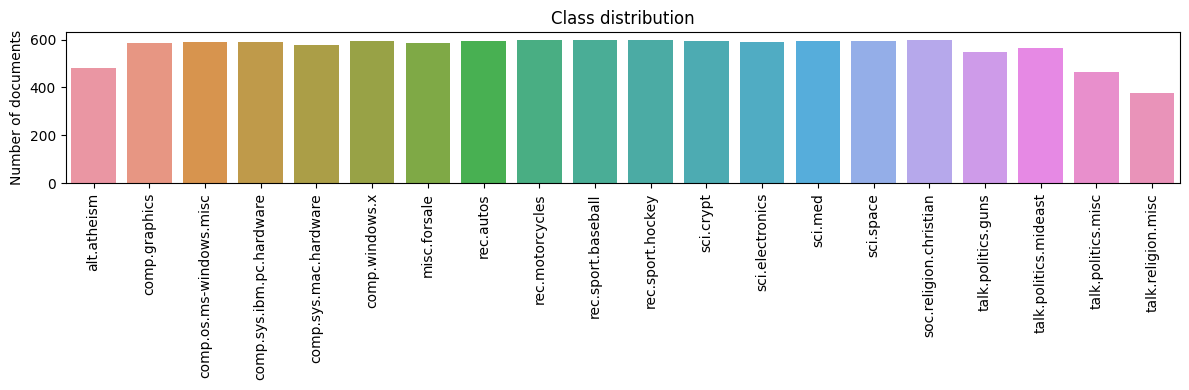

In [7]:
# Showing how many documents are in each class

train_df = pd.DataFrame({"text": X_train_clean, "label": y_train})
class_counts = train_df["label"].value_counts().sort_index()

plt.figure(figsize=(12, 4))
sns.barplot(x=list(range(len(target_names))), y=class_counts.values)
plt.xticks(ticks=range(len(target_names)), labels=target_names, rotation=90)
plt.title("Class distribution")
plt.ylabel("Number of documents")
plt.tight_layout()
plt.show()


## Modeling

I will now build two different models for the 20 Newsgroups classification task and compare their performance. I first start off with the TF-IDF approach with Logisitic Regression. Then I go to the second model to utilize a deep learning architecture.

By evaluating both models under similar conditions, we are able to compare linear methods against deep learning methods.

### TF-IDF

The TF-IDF model converts each document into a high-dimensional vector. TF-IDF highlights words that are important within a document but not too common across the entirety of the documents.

Some key steps in modeling:

- Build a vocabulary of the most frequent unigrams and bigrams
- Transform the cleaned documents into TF-IDF feature vectors
- Train a Logistic Regression classifier to predict one of 20 classes

This will provide a good benchmark for the deep learning model to compare against, as TF-IDF + Linear Regression generally performs well on text based tasks.

### GloVe + Deep Learning Model

This model uses pre-trained GloVe embeddings to map the words to a semantic meaning.

Some key steps in modeling:

- Convert each cleaned document into a sequence of word indices.
- Load GloVe embeddings and match the dataset vocabulary
- Feed embedded sequences into a neural model
- Train the model to predict one of the 20 classes

This provides a way for the model to learn patterns in the text, and will allow the model to hopefully learn semantic meaning of the structure and words used in the document.

### Hyperparameters and Training Setup

#### **TF-IDF + Logistic Regression**
- max_features: 50,000  
- ngram_range: (1, 2)  
- Regularization: L2
- max_iter: 1000  
- Optimization: LBFGS solver

#### **GloVe + BiLSTM Model**
- Embedding dimension: 100  
- Sequence length cap: 400 tokens  
- Hidden size: 128  
- Dropout: 0.5  
- Batch size: 64  
- Optimizer: Adam
- Loss function: Cross-entropy  
- Epochs: 50


In [7]:
# Setting up the TF–IDF vectorization

tfidf_vectorizer = TfidfVectorizer(
    max_features=50000, 
    ngram_range=(1, 2), 
    min_df=2,
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean)
X_test_tfidf = tfidf_vectorizer.transform(X_test_clean)

X_train_tfidf.shape, X_test_tfidf.shape


((11314, 50000), (7532, 50000))

In [8]:
# Train the Logistic Regression model

baseline_clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
)

baseline_clf.fit(X_train_tfidf, y_train)

y_pred_baseline = baseline_clf.predict(X_test_tfidf)

print("Baseline accuracy:", accuracy_score(y_test, y_pred_baseline))
print(classification_report(y_test, y_pred_baseline, target_names=target_names))


Baseline accuracy: 0.661311736590547
                          precision    recall  f1-score   support

             alt.atheism       0.47      0.43      0.45       319
           comp.graphics       0.57      0.68      0.62       389
 comp.os.ms-windows.misc       0.64      0.60      0.62       394
comp.sys.ibm.pc.hardware       0.67      0.61      0.64       392
   comp.sys.mac.hardware       0.73      0.65      0.69       385
          comp.windows.x       0.77      0.66      0.71       395
            misc.forsale       0.74      0.81      0.77       390
               rec.autos       0.68      0.66      0.67       396
         rec.motorcycles       0.66      0.75      0.70       398
      rec.sport.baseball       0.49      0.82      0.61       397
        rec.sport.hockey       0.87      0.85      0.86       399
               sci.crypt       0.84      0.64      0.73       396
         sci.electronics       0.56      0.59      0.58       393
                 sci.med       0.73   

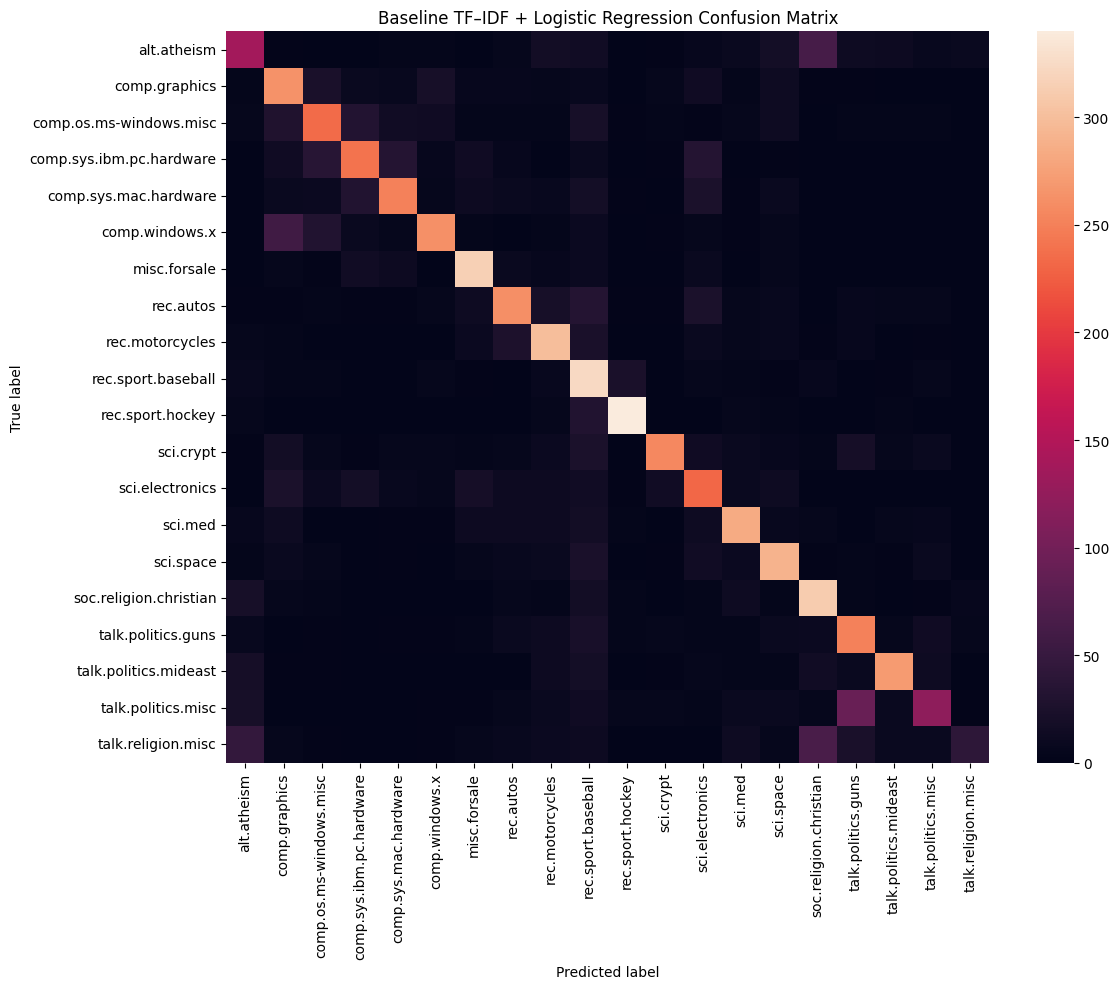

In [9]:
# Showing a confusion matrix

cm_baseline = confusion_matrix(y_test, y_pred_baseline)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_baseline,
    xticklabels=target_names,
    yticklabels=target_names,
    annot=False,
    fmt="d"
)
plt.title("Baseline TF–IDF + Logistic Regression Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


In [10]:
# Hyperparameters
MAX_VOCAB_SIZE = 30000 
MAX_SEQ_LEN = 400    
EMBEDDING_DIM = 100     
UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"

# Build vocabulary from training data
word_counter = Counter()
for text in X_train_clean:
    word_counter.update(text.split())

most_common = word_counter.most_common(MAX_VOCAB_SIZE - 2)
itos = [PAD_TOKEN, UNK_TOKEN] + [w for w, _ in most_common]
stoi = {w: i for i, w in enumerate(itos)}

vocab_size = len(itos)
vocab_size


30000

In [11]:
# Change the text to an indice sequence

def text_to_indices(text, stoi, max_len=MAX_SEQ_LEN):
    tokens = text.split()
    idxs = [stoi.get(tok, stoi[UNK_TOKEN]) for tok in tokens[:max_len]]
    return torch.tensor(idxs, dtype=torch.long)

X_train_indices = [text_to_indices(t, stoi) for t in X_train_clean]
X_test_indices = [text_to_indices(t, stoi) for t in X_test_clean]


In [12]:
# Loading the GloVe text file

def load_glove(path, embedding_dim=100):
    embeddings_index = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            if len(coefs) != embedding_dim:
                continue
            embeddings_index[word] = coefs
    return embeddings_index

glove_path = "/kaggle/input/glove100/glove.6B.100d.txt"
glove_index = load_glove(glove_path, embedding_dim=EMBEDDING_DIM)

embedding_matrix = np.random.normal(
    scale=0.6, size=(vocab_size, EMBEDDING_DIM)
).astype(np.float32)

for word, i in stoi.items():
    vec = glove_index.get(word)
    if vec is not None:
        embedding_matrix[i] = vec

embedding_matrix = torch.tensor(embedding_matrix)
embedding_matrix.shape


torch.Size([30000, 100])

In [13]:
# Utilizing the PyTorch dataset and the dataloader

class NewsGroupDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def collate_fn(batch):
    seqs, labels = zip(*batch)
    seqs_padded = pad_sequence(seqs, batch_first=True, padding_value=stoi[PAD_TOKEN])
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return seqs_padded, labels_tensor

train_dataset = NewsGroupDataset(X_train_indices, y_train)
test_dataset = NewsGroupDataset(X_test_indices, y_test)

BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)


In [14]:
# Deep Learning model BiLSTM

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, embedding_matrix=None, freeze_embeddings=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(embedding_matrix)
        if freeze_embeddings:
            self.embedding.weight.requires_grad = False
        
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(2 * hidden_dim, num_classes)
    
    def forward(self, x):
        emb = self.embedding(x)
        outputs, (h_n, c_n) = self.lstm(emb)
        h_cat = torch.cat((h_n[0], h_n[1]), dim=1) 
        h_cat = self.dropout(h_cat)
        logits = self.fc(h_cat)
        return logits

num_classes = len(target_names)
HIDDEN_DIM = 128 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTMClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix,
    freeze_embeddings=False,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [15]:
# Setup for training an epoch and then evaluating the model

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == batch_y).sum().item()
        total_examples += batch_x.size(0)
    
    return total_loss / total_examples, total_correct / total_examples

def eval_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            
            total_loss += loss.item() * batch_x.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == batch_y).sum().item()
            total_examples += batch_x.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / total_examples
    avg_acc = total_correct / total_examples
    return avg_loss, avg_acc, np.array(all_preds), np.array(all_labels)


In [16]:
# Actually training the model

EPOCHS = 50

train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc, y_pred_dl, y_true_dl = eval_model(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1/50 | Train Loss: 2.8828, Train Acc: 0.1020 | Test Loss: 2.5698, Test Acc: 0.1583
Epoch 2/50 | Train Loss: 2.5277, Train Acc: 0.1598 | Test Loss: 2.4571, Test Acc: 0.1899
Epoch 3/50 | Train Loss: 2.1812, Train Acc: 0.2525 | Test Loss: 2.0633, Test Acc: 0.2860
Epoch 4/50 | Train Loss: 1.8345, Train Acc: 0.3506 | Test Loss: 1.8468, Test Acc: 0.3660
Epoch 5/50 | Train Loss: 1.5348, Train Acc: 0.4510 | Test Loss: 1.5802, Test Acc: 0.4466
Epoch 6/50 | Train Loss: 1.2487, Train Acc: 0.5540 | Test Loss: 1.4835, Test Acc: 0.5100
Epoch 7/50 | Train Loss: 1.0520, Train Acc: 0.6352 | Test Loss: 1.3886, Test Acc: 0.5619
Epoch 8/50 | Train Loss: 0.8604, Train Acc: 0.7150 | Test Loss: 1.3404, Test Acc: 0.5856
Epoch 9/50 | Train Loss: 0.6938, Train Acc: 0.7814 | Test Loss: 1.3648, Test Acc: 0.6009
Epoch 10/50 | Train Loss: 0.5634, Train Acc: 0.8289 | Test Loss: 1.4259, Test Acc: 0.6079
Epoch 11/50 | Train Loss: 0.4785, Train Acc: 0.8621 | Test Loss: 1.5089, Test Acc: 0.6008
Epoch 12/50 | Train

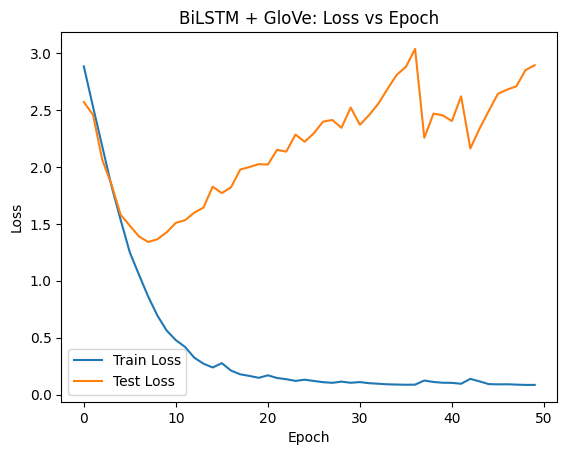

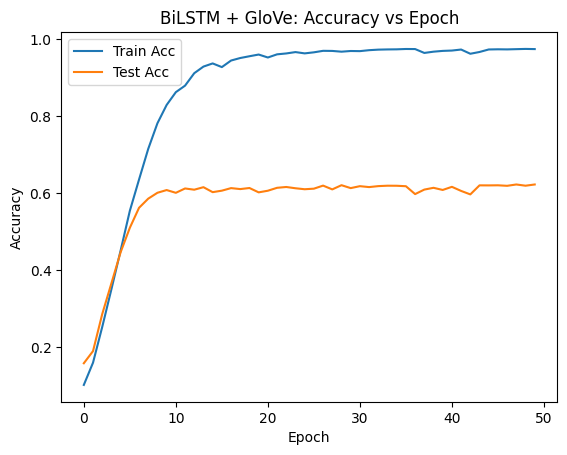

In [17]:
# Plotting the results from the model

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BiLSTM + GloVe: Loss vs Epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("BiLSTM + GloVe: Accuracy vs Epoch")
plt.legend()
plt.show()


Deep model (BiLSTM + GloVe) classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.37      0.44      0.40       319
           comp.graphics       0.53      0.63      0.58       389
 comp.os.ms-windows.misc       0.59      0.49      0.54       394
comp.sys.ibm.pc.hardware       0.56      0.59      0.58       392
   comp.sys.mac.hardware       0.63      0.63      0.63       385
          comp.windows.x       0.77      0.61      0.68       395
            misc.forsale       0.74      0.72      0.73       390
               rec.autos       0.47      0.71      0.57       396
         rec.motorcycles       0.71      0.66      0.68       398
      rec.sport.baseball       0.84      0.75      0.79       397
        rec.sport.hockey       0.86      0.86      0.86       399
               sci.crypt       0.72      0.68      0.70       396
         sci.electronics       0.48      0.52      0.50       393
                 sci.med

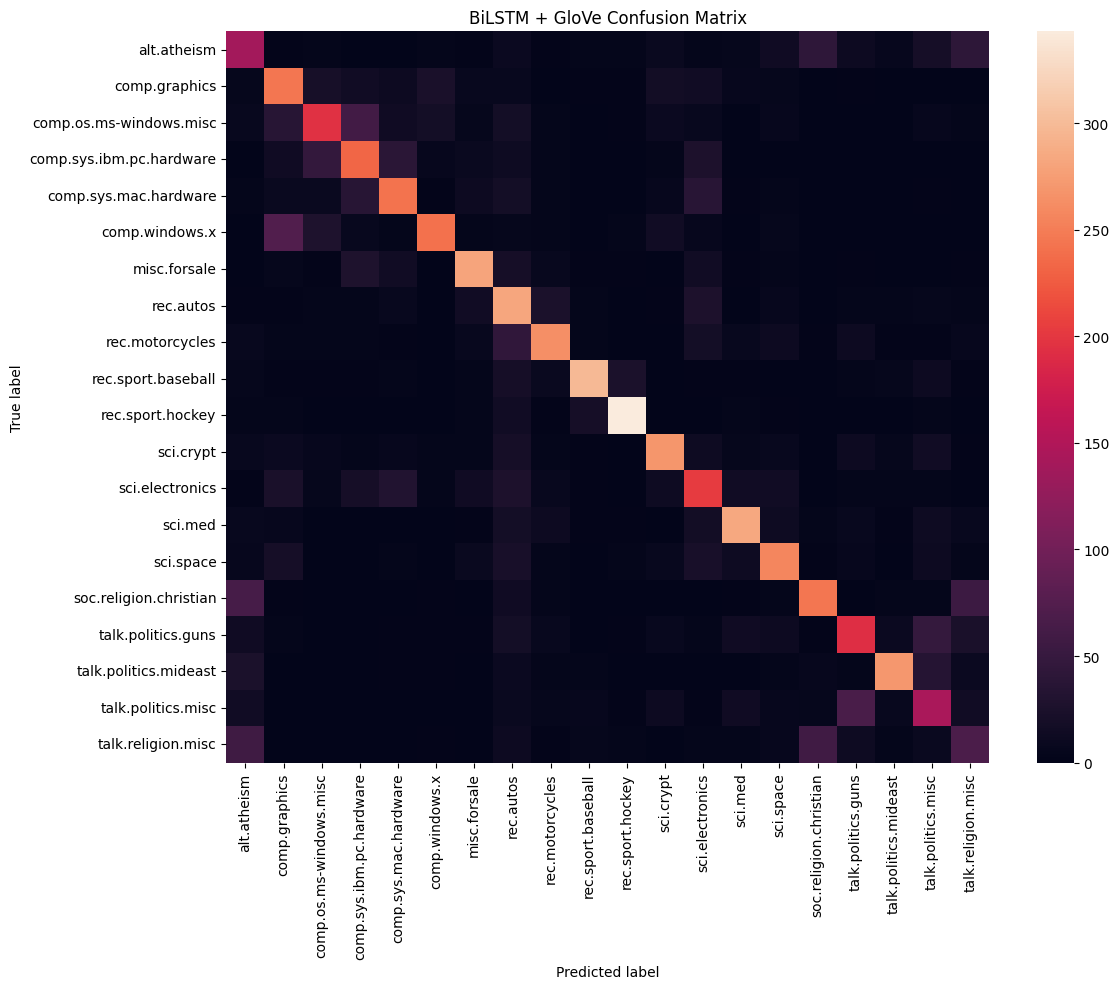

In [18]:
# Report and confusion matrix for the deep learning model

print("BiLSTM + GloVe classification report:")
print(classification_report(y_true_dl, y_pred_dl, target_names=target_names))

cm_dl = confusion_matrix(y_true_dl, y_pred_dl)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_dl,
    xticklabels=target_names,
    yticklabels=target_names,
    annot=False,
    fmt="d"
)
plt.title("BiLSTM + GloVe Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


## Results, Analysis, and Discussion

### TF-IDF

- Accuracy: ~0.66  
- Macro F1: ~0.65  
- Performs consistently across most categories  
- The confusion matrix shows strong diagonal structure
- Handles subtle frequency-based distinctions between newsgroups extremely well  

This confirms that TF-IDF is a good baseline for text-based modeling.

### GloVe + Deep Learning Model

- Final Accuracy: ~0.62  
- Macro F1: ~0.62
- Confusion matrix shows a strong diagonal
- Stable class predictions for nearly all categories  
- Strong performance on sports and science categories where semantic cues matter  

Training behavior:

- Train accuracy rises steadily and plateaus near 97%
- Test accuracy converges around 62%
- Train loss drops to near zero
- Test loss decreases early on, then gradually increases. This indicates overfitting around 15-20 epochs.

### Comparing Models

| Model | Test Accuracy | Macro F1 | Strengths |
|-------|---------------|-----------|-----------|
| TF-IDF + Logistic Regression | ~0.66 | ~0.65 | Strong linear baseline |
| GloVe + Deep Learning | ~0.62 | ~0.62 | Captures semantic/contextual information, performs well on meaning-rich classes |

### Limitations of TF-IDF

- No understanding of word meaning  
- Treats documents as unordered bags of words  
- Cannot generalize across synonyms or phrases  

### Limitations of GloVe + Deep Learning

- Overfitting after epoch ~15-20
- Long documents are truncated, which loses important information
- The dataset is not large enough for the model to fully generalize it

### Ways to Improve

- Add dropout, weight decay, or early stopping to reduce overfitting  
- Try CNN text classifiers. They are generally better for longer documents
- Try changing max sequence length in training
- Could try applying cyclic learning rate schedules

## Conclusion

- Deep learning models are comparable to classical methods even with moderate data sizes, given enough training time.  
- TF-IDF remains a very strong baseline for modeling text. Especially with these longer documents.  
- Deep learning benefits from more data, more tuning, and more advanced architectures, and is not automatically superior without these conditions. 

Overall, the models had very similar accuracy and the were able to model the dataset sufficently well. The deep learning model would benefit from more data, and more advanced architectures, but still gave a good comparison for the TF-IDF model.

## References

- 20 Newsgroups dataset (sklearn)
- GloVe: Pennington, Socher, Manning. "GloVe: Global Vectors for Word Representation" (2014).

## Github URL

https://github.com/SweetBabyDave/CSCA-5642-Final/tree/main